NOTE: Analysis is done in two jupyter notebooks. This is part 1.
### Preliminary steps.

In [1]:
# Supress Warnings.

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import important libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [3]:
# Jupyter Notebook will display all rows and columns this way. Use ctrl+/ to comment/un-comment.

from IPython.display import display
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [4]:
# # Check the encoding of data. Use ctrl+/ to comment/un-comment.

# import chardet

# rawdata = open('Country-data.csv', 'rb').read()
# result = chardet.detect(rawdata)
# charenc = result['encoding']
# print(charenc)
# print(result) # It's ascii with 100% confidence.

In [5]:
# Read csv data.

df = pd.read_csv('Country-data.csv', encoding='ascii')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB
None


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [6]:
print(len(df.drop_duplicates().index) == len(df.index)) # Check for duplicate rows.
df.columns.nunique() == len(df.columns) # Check for duplicate columns.

True


True

Hence, no duplicate columns or rows. Also, see output of info. It has no null values.
<br> <hr>
## 1. Data Cleaning
`exports`, `health` and `imports` are given as a percccentage of `gdpp`.

In [7]:
df['exports'] = df['exports']*df['gdpp']/100
df['health'] = df['health']*df['gdpp']/100
df['imports'] = df['imports']*df['gdpp']/100
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


Let's plot the correlation matrix now.

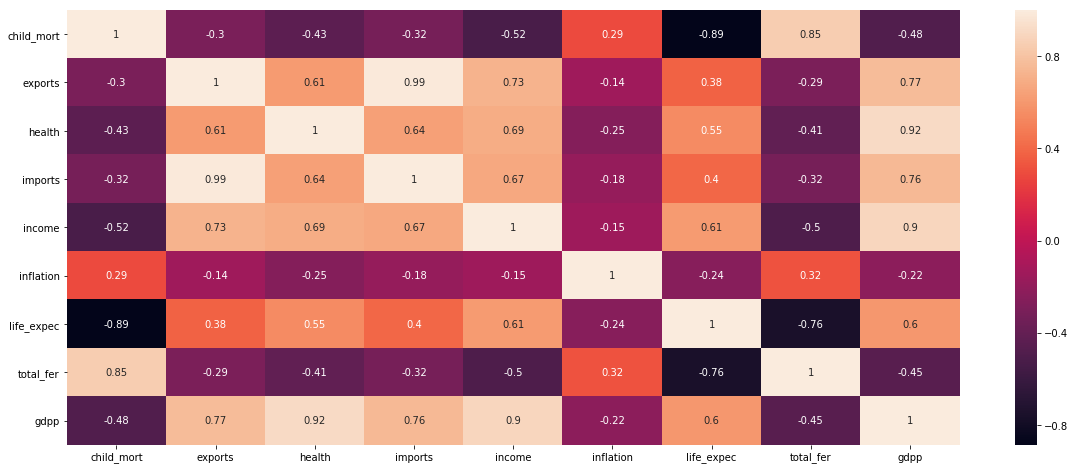

In [8]:
plt.figure(figsize = (20,8))        
sns.heatmap(df.corr(),annot = True)

We can see that we have many correlated features.<br><br>
From `df.info()` it can be seen that all the columns except `country` are numerical. Let's use `describe` function to check them.

In [9]:
pd.set_option('display.precision', 2) # Will only show values till 2-decimal places.
df.describe(percentiles=[.1,.25,.5,.75,.9,.95,.99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00
mean,38.27,7420.62,1056.73,6588.35,17144.69,7.78,70.56,2.95,12964.16
std,40.33,17973.89,1801.41,14710.81,19278.07,10.57,8.89,1.51,18328.70
min,2.60,1.08,12.82,0.65,609.00,-4.21,32.10,1.15,231.00
10%,4.20,110.22,36.50,211.01,1524.00,0.59,57.82,1.45,593.80
25%,8.25,447.14,78.54,640.21,3355.00,1.81,65.30,1.79,1330.00
50%,19.30,1777.44,321.89,2045.58,9960.00,5.39,73.10,2.41,4660.00
75%,62.10,7278.00,976.94,7719.60,22800.00,10.75,76.80,3.88,14050.00
90%,100.22,17760.60,3825.42,15034.28,41220.00,16.64,80.40,5.32,41840.00
95%,116.00,31385.10,4966.70,24241.56,48290.00,20.87,81.40,5.86,48610.00


We can see that some columns have extremely high or low values. There is also significant jump from 95 to 99 percentile. They are outliers and they need to be treated as we are performing clustering.

In [10]:
df_outlier = pd.DataFrame(columns=df.columns) # create a new dataframe that contains only outliers.

# Treat outliers.
col_list = list(df.columns) # list of all column names.
col_list.remove('country') # remove `country` as it is not a numerical type column.

for col in col_list:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df_outlier = pd.concat([df_outlier, df[~((df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR))]], axis=0)
    df = df[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]
    
print(df_outlier.shape, df.shape)

(56, 10) (111, 10)


So, 56 rows are outliers. We will perform rest of the steps on the remaining 111.<br> <hr>
## 2. Modeling
Now, let us use PCA for dimensionality reduction. But, we will have to standardise the features before we begin.

In [11]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
df_s = df[col_list]
df_s = standard_scaler.fit_transform(df_s) # s in df_s stands for scaled.

E:\Users\ASHISH\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
E:\Users\ASHISH\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [12]:
# Improting the PCA module.

from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=123)

In [13]:
# Doing the PCA on the data.
pca.fit(df_s)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=123,
  svd_solver='randomized', tol=0.0, whiten=False)

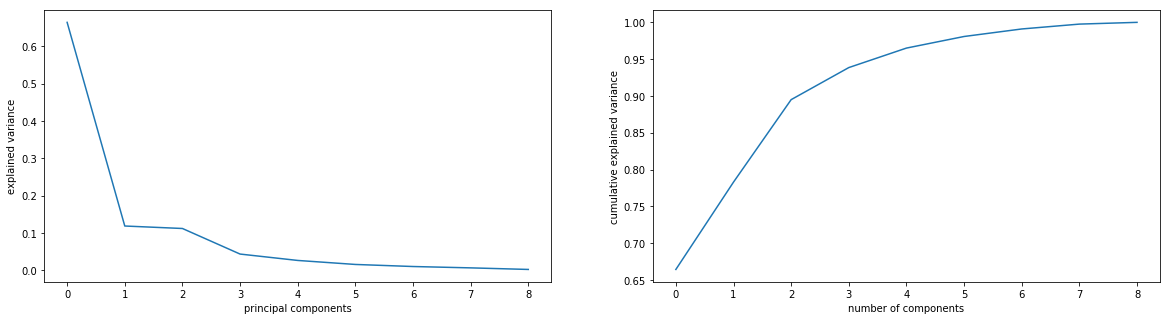

In [14]:
# Making the screeplot - plotting the cumulative variance against the number of components

fig = plt.figure(figsize = (20,5))
ax = plt.subplot(121)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('principal components')
plt.ylabel('explained variance')

ax2 = plt.subplot(122)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.show()

In [15]:
# what percentage of variance in data can be explained by first 3,4 and 5 principal components respectively?
(pca.explained_variance_ratio_[0:3].sum().round(3),
pca.explained_variance_ratio_[0:4].sum().round(3),
pca.explained_variance_ratio_[0:5].sum().round(3))

(0.895, 0.939, 0.965)

Thus, first three, four and five components explain 89.5%, 93.9% and 96.5% variance respectively.<br><br>
Check:https://www.r-bloggers.com/pca-and-k-means-clustering-of-delta-aircraft/<br>
It says: There are various rules of thumb for selecting the number of principal components to retain in an analysis of this type, two of which are:

1. Pick the number of components which explain 85% or greater of the variation.
2. Use the ‘elbow’ method of the scree plot (on left, which has explained variance on y-axis).<br>

As elbow is not very clear on the left plot, we'll use the cumulative explained variance plt on the right. Thus, we can stat by selecting first 3 principal components as they explain 89.5% of the variance.

In [16]:
pca.components_.round(2) # loadings for all the original features.

array([[-0.34,  0.34,  0.35,  0.36,  0.38, -0.09,  0.32, -0.33,  0.38],
       [ 0.32,  0.32,  0.18,  0.07,  0.25,  0.63, -0.35,  0.34,  0.26],
       [-0.31, -0.24, -0.13, -0.31,  0.05,  0.72,  0.35, -0.29, -0.09],
       [ 0.11, -0.52,  0.65, -0.42,  0.08, -0.13, -0.02,  0.05,  0.31],
       [-0.16, -0.06, -0.01, -0.03,  0.06,  0.01, -0.77, -0.62, -0.01],
       [ 0.45,  0.19, -0.37, -0.47,  0.5 , -0.2 ,  0.15, -0.25,  0.14],
       [-0.65,  0.03, -0.26, -0.29,  0.32, -0.15, -0.22,  0.48,  0.16],
       [-0.12,  0.63,  0.25, -0.53, -0.49, -0.03,  0.01, -0.07, -0.01],
       [ 0.03, -0.12, -0.37,  0.07, -0.44,  0.03,  0.02, -0.06,  0.8 ]])

In [17]:
# we'll use first 3 principal components.

df_pca_3_comp = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1],'PC3':pca.components_[2], 
                              'Feature':col_list})
df_pca_3_comp

,PC1,PC2,PC3,Feature
0,-0.34,0.32,-0.31,child_mort
1,0.34,0.32,-0.24,exports
2,0.35,0.18,-0.13,health
3,0.36,0.07,-0.31,imports
4,0.38,0.25,0.05,income
5,-0.09,0.63,0.72,inflation
6,0.32,-0.35,0.35,life_expec
7,-0.33,0.34,-0.29,total_fer
8,0.38,0.26,-0.09,gdpp


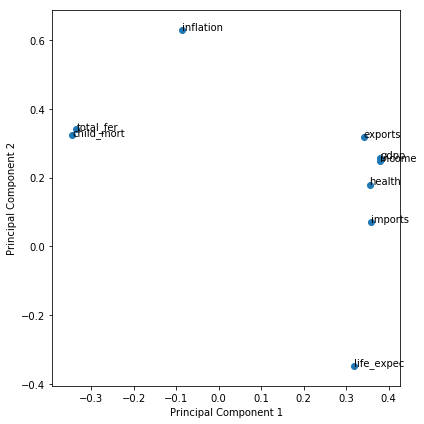

In [18]:
# we can visualize what the principal components seem to capture.

fig = plt.figure(figsize = (6,6))
plt.scatter(df_pca_3_comp.PC1, df_pca_3_comp.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(df_pca_3_comp.Feature):
    plt.annotate(txt, (df_pca_3_comp.PC1[i],df_pca_3_comp.PC2[i]))
plt.tight_layout()
plt.show()

On first principal component, imports, health, exports, gdpp, life_expec, income seem to be on right side, and inflation, total_fer and child_mort seem tobe on the left side. Similarly, for second principal component inflation is on the highest point and life_expec is on the lower side. The reason that some features appear together is because these features are correlated and vary together. Check the correlation heatmap plotted above.<br><br>
Now, we had established earlier that we will start with our modeling with 3 principal components. For that we first need to transform our data.

In [19]:
df_s.round(2)[0:5] # our original data, but scaled.

array([[ 1.29, -0.91, -0.83, -0.93, -1.05,  0.25, -1.6 ,  1.69, -1.  ],
       [-0.85, -0.21,  0.08,  0.24,  0.36, -0.58,  1.13, -1.08,  0.09],
       [-0.54,  0.16, -0.25, -0.16,  0.87,  1.38,  1.16, -0.26,  0.2 ],
       [ 2.12,  0.47, -0.59, -0.08, -0.32,  2.44, -1.07,  1.91, -0.09],
       [-0.91,  0.31,  2.34,  0.01,  1.85,  2.18,  1.06, -0.61,  1.99],
       [-0.8 , -0.52, -0.43, -0.12, -0.18, -0.03,  0.72, -1.06, -0.18],
       [-0.19,  1.1 ,  0.38, -0.29,  1.4 ,  0.99,  0.15, -0.91,  0.62],
       [ 0.11, -0.87, -0.89, -0.99, -0.91, -0.13,  0.33, -0.63, -0.93],
       [-1.17,  1.05,  0.36,  1.51,  1.43,  1.21,  0.33, -1.19,  0.68],
       [-0.78,  0.68, -0.09,  0.58,  0.02, -1.14,  0.47, -0.38,  0.16],
       [ 1.89, -0.83, -0.87, -0.91, -1.01, -1.19, -0.84,  1.38, -0.93],
       [-0.09, -0.35, -0.54, -0.06, -0.23, -0.33,  0.56, -0.6 , -0.5 ],
       [ 0.02, -0.42, -0.61, -0.64, -0.4 ,  0.14,  0.49, -0.05, -0.56],
       [-1.13, -0.06,  1.05,  0.49,  0.33, -1.1 ,  1.2 , -1.31, 

In [20]:
df_pca_tr = pca.transform(df_s) # our data transformed with new features as principal components.
df_pca_tr.round(2)[0:5]

array([[-3.26,  0.69, -0.61,  0.17,  0.02, -0.22,  0.26, -0.08, -0.06],
       [ 1.27, -1.32,  0.53,  0.02, -0.05,  0.19, -0.1 , -0.2 , -0.04],
       [ 0.84,  0.46,  1.7 , -0.32, -0.57,  0.38,  0.19, -0.24, -0.09],
       [-2.15,  3.18,  0.14, -0.61, -0.7 ,  0.  , -0.5 , -0.12,  0.24],
       [ 3.07,  1.99,  1.95,  1.68, -0.23, -0.16,  0.05, -0.03, -0.04],
       [ 0.35, -1.23,  1.01, -0.19,  0.26,  0.02, -0.1 , -0.1 ,  0.2 ],
       [ 1.51,  1.1 ,  0.88, -0.1 ,  0.5 ,  0.95,  0.07,  0.32, -0.32],
       [-1.38, -1.35,  0.84, -0.09,  0.17,  0.33, -0.37,  0.24,  0.07],
       [ 2.64,  0.89,  0.93, -0.98,  0.65, -0.26, -0.01, -0.55, -0.16],
       [ 1.12, -0.98, -0.65, -0.57, -0.07, -0.03,  0.29,  0.25,  0.08],
       [-2.94, -0.35, -1.51,  0.33, -0.49,  0.58, -0.21, -0.07, -0.02],
       [-0.18, -1.03,  0.37, -0.33, -0.03,  0.24, -0.31, -0.14, -0.02],
       [-0.81, -0.62,  0.69, -0.14, -0.31,  0.24, -0.05,  0.13, -0.02],
       [ 2.05, -1.57,  0.08,  0.54,  0.05, -0.21, -0.28,  0.08, 

In [21]:
df_pca3 = df_pca_tr[:,0:3] # since we only require first 3 principal components to explain 89.5% variance.
df_pca3.round(2)[0:5] # look at first 5 rows.

array([[-3.26,  0.69, -0.61],
       [ 1.27, -1.32,  0.53],
       [ 0.84,  0.46,  1.7 ],
       [-2.15,  3.18,  0.14],
       [ 3.07,  1.99,  1.95]])

In [22]:
np.corrcoef(df_pca3.T).round(2)

array([[ 1., -0., -0.],
       [-0.,  1.,  0.],
       [-0.,  0.,  1.]])

So it can be seen that PCA has found new components that are not correlated at all. All the diagonal elements are 1, because the same feature is obviously perfectly correlated with itself. But, all the non-diagonal elements are 0. It means no two different features have any correlation.

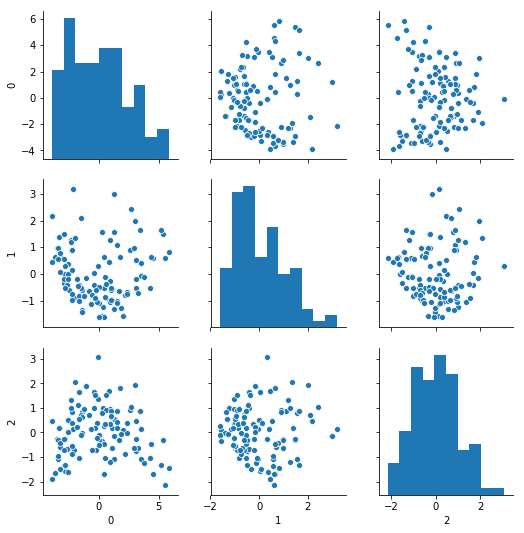

In [23]:
sns.pairplot(pd.DataFrame(df_pca3)) # Try to get some intuiton of data.

Hopkin's Statstic will tell us if the data is clusterable or not. If it is less than 0.5, clusters are not statistically significant.

In [24]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [25]:
hopkins(pd.DataFrame(df_pca3))

0.7500462442657155

Since random_state is not specified inside the `hopkins` function, the Hopkin Statistic shows different values everytime. But, I ran it 5 times and the values were between .60 to .80.<br><br>
Let us now apply clustering algorithm on it.
### 2.a. K-means Clustering.

In [26]:
# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

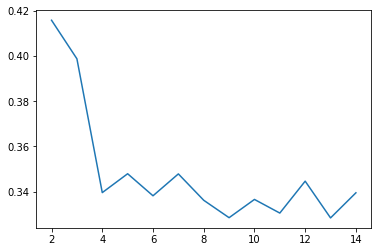

In [27]:
# silhouette scores.

from sklearn.metrics import silhouette_score
def sil_score(df):
    sse_ = []
    for k in range(2, 15):
        kmeans = KMeans(n_clusters=k, random_state=111).fit(df)
        sse_.append([k, silhouette_score(df, kmeans.labels_)])
    plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])

sil_score(df_pca3)

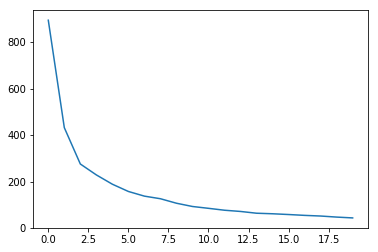

In [28]:
# sum of squared distances

def plot_ssd(df):
    ssd = []
    for num_clusters in list(range(1,21)):
        model_clus = KMeans(n_clusters = num_clusters, max_iter=50, random_state=111)
        model_clus.fit(df)
        ssd.append(model_clus.inertia_)
    plt.plot(ssd)

plot_ssd(df_pca3)

Elbow in ssd curve seems to be at 3. Let's try 3 and 4 clusters first and see if clusters make sense.

### 2.a.i. 3 clusters.

In [29]:
# Kmeans with K=3
model_clus3 = KMeans(n_clusters = 3, max_iter=50, random_state=111)
model_clus3.fit(df_pca3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=111, tol=0.0001, verbose=0)

In [30]:
# creation of data frame with original features for analysis of clusters formed.

df_dummy = pd.DataFrame.copy(df)
df_dummy.reset_index(inplace=True)
df_3_clus = pd.concat([df_dummy, pd.Series(model_clus3.labels_)], axis=1)
df_3_clus.head()

,index,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,0
0,0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553,0
1,1,Albania,16.6,1145.20,267.89,1987.74,9930,4.49,76.3,1.65,4090,1
2,2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460,1
3,3,Angola,119.0,2199.19,100.61,1514.37,5900,22.40,60.1,6.16,3530,0
4,5,Argentina,14.5,1946.70,834.30,1648.00,18700,20.90,75.8,2.37,10300,2


Let's see how the clusters are assigned to the pairplot plotted above.

In [31]:
# creation of data frame with features as principal components for analysis of clusters formed.

df_dummy = pd.DataFrame.copy(pd.DataFrame(df_pca3))
df_pca3_k3 = pd.concat([df_dummy, pd.Series(model_clus3.labels_)], axis=1)
df_pca3_k3.columns = ['PC1', 'PC2', 'PC3', 'ClusterID']

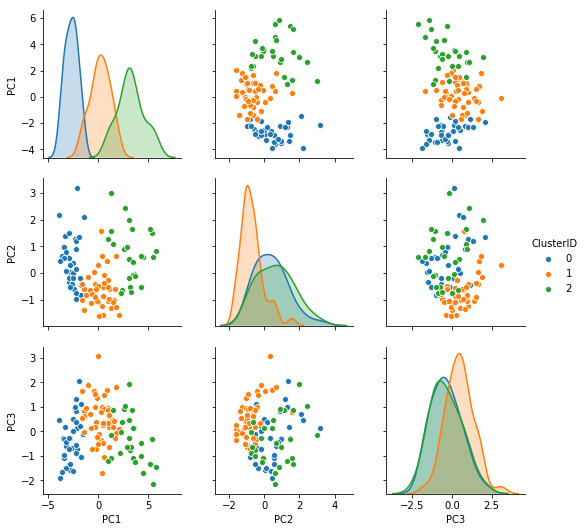

In [32]:
sns.pairplot(data = df_pca3_k3, vars=['PC1', 'PC2', 'PC3'], hue='ClusterID')

Let's try to get some intuition in 3D.

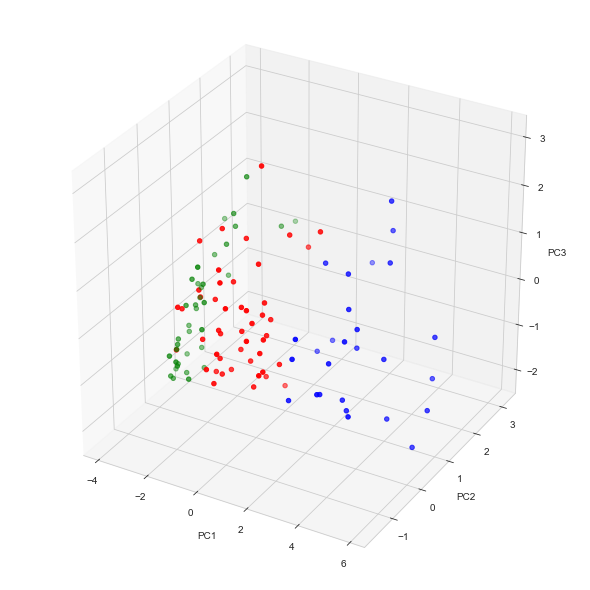

In [33]:
import re
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig) 
ax.scatter(df_pca3_k3['PC1'], df_pca3_k3['PC2'], df_pca3_k3['PC3'],
           c=df_pca3_k3['ClusterID'].map({0:'green', 1:'red', 2:'blue'}), marker='o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

### 2.a.ii. 4 clusters.

In [34]:
# Kmeans with K=4
model_clus4 = KMeans(n_clusters = 4, max_iter=50, random_state=111)
model_clus4.fit(df_pca3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=111, tol=0.0001, verbose=0)

In [35]:
# creation of data frame with original features for analysis of clusters formed.

df_dummy = pd.DataFrame.copy(df)
df_dummy.reset_index(inplace=True)
df_4_clus = pd.concat([df_dummy, pd.Series(model_clus4.labels_)], axis=1)
df_4_clus.head()

,index,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,0
0,0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553,3
1,1,Albania,16.6,1145.20,267.89,1987.74,9930,4.49,76.3,1.65,4090,2
2,2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460,2
3,3,Angola,119.0,2199.19,100.61,1514.37,5900,22.40,60.1,6.16,3530,3
4,5,Argentina,14.5,1946.70,834.30,1648.00,18700,20.90,75.8,2.37,10300,0


In [36]:
# creation of data frame with features as principal components for analysis of clusters formed.

df_dummy = pd.DataFrame.copy(pd.DataFrame(df_pca3))
df_pca3_k4 = pd.concat([df_dummy, pd.Series(model_clus4.labels_)], axis=1)
df_pca3_k4.columns = ['PC1', 'PC2', 'PC3', 'ClusterID']

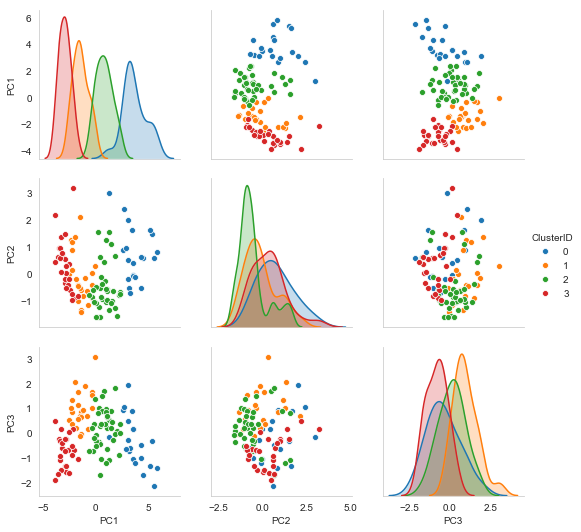

In [37]:
sns.pairplot(data = df_pca3_k4, vars=['PC1', 'PC2', 'PC3'], hue='ClusterID')

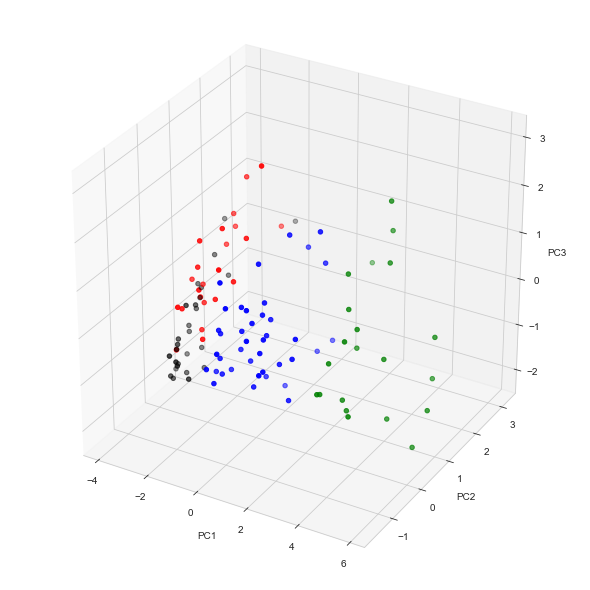

In [38]:
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig) 
ax.scatter(df_pca3_k4['PC1'], df_pca3_k4['PC2'], df_pca3_k4['PC3'],
           c=df_pca3_k4['ClusterID'].map({0:'green', 1:'red', 2:'blue', 3:'black'}), marker='o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

## 2.b. Hierarchical clustering.

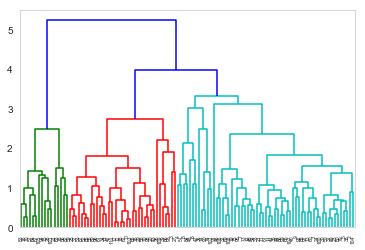

In [39]:
# heirarchical clustering. method:average

mergings = linkage(df_pca3, method = "average", metric='euclidean')
dendrogram(mergings)
plt.show()

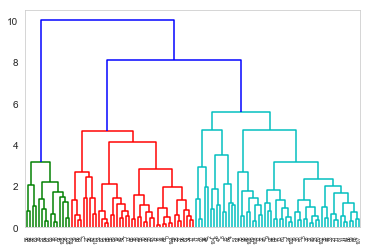

In [40]:
# heirarchical clustering. method:complete

mergings2 = linkage(df_pca3, method = "complete", metric='euclidean')
dendrogram(mergings2)
plt.show()

'complete' merging method seems to form better and distinct clusters in this case.

### 2.b.i. 3 clusters.

In [41]:
# 3 clusters.
clusterCut = pd.Series(cut_tree(mergings2, n_clusters = 3).reshape(-1,)) # merging2 is used here. linkage:'complete'

In [42]:
# creation of data frame with original features for analysis of clusters formed.

df_dummy = pd.DataFrame.copy(df)
df_dummy.reset_index(inplace=True)
df_3_clus_hr = pd.concat([df_dummy, clusterCut], axis=1) # 3_clus stands for 3 clusters. hr stands for hierarchical.
df_3_clus_hr.head()

,index,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,0
0,0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553,0
1,1,Albania,16.6,1145.20,267.89,1987.74,9930,4.49,76.3,1.65,4090,1
2,2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460,1
3,3,Angola,119.0,2199.19,100.61,1514.37,5900,22.40,60.1,6.16,3530,0
4,5,Argentina,14.5,1946.70,834.30,1648.00,18700,20.90,75.8,2.37,10300,1


In [43]:
# creation of data frame with features as principal components for analysis of clusters formed.

df_dummy = pd.DataFrame.copy(pd.DataFrame(df_pca3))
df_pca3_c3_hr = pd.concat([df_dummy, clusterCut], axis=1) # pca4 stands for 4 principal components. c3 for 3 clusters.
df_pca3_c3_hr.columns = ['PC1', 'PC2', 'PC3', 'ClusterID']

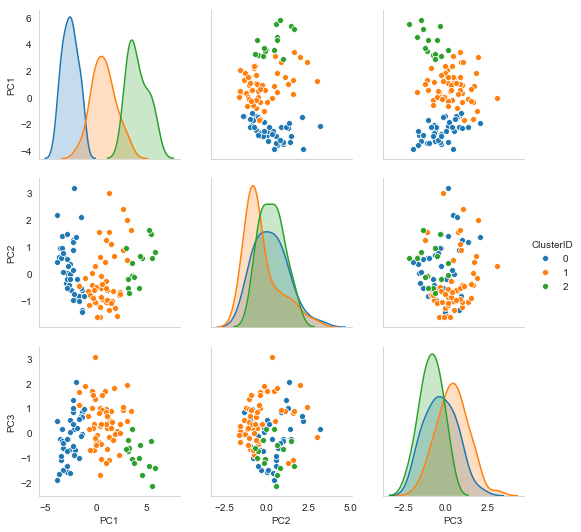

In [44]:
sns.pairplot(data = df_pca3_c3_hr, vars=['PC1', 'PC2', 'PC3'], hue='ClusterID')

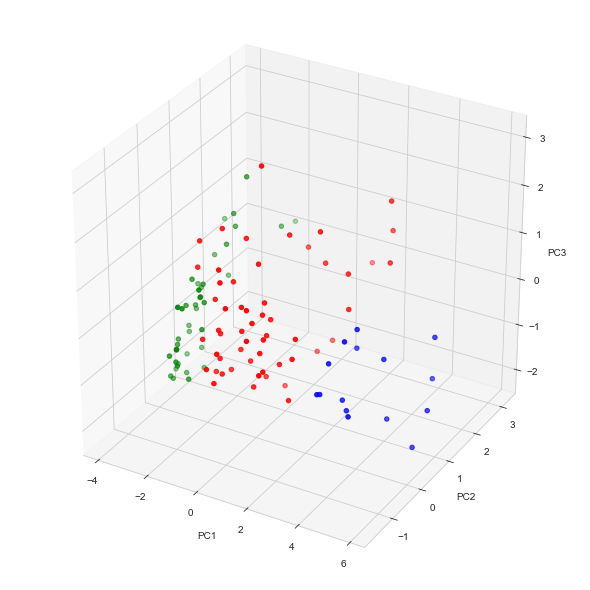

In [45]:
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig) 
ax.scatter(df_pca3_c3_hr['PC1'], df_pca3_c3_hr['PC2'], df_pca3_c3_hr['PC3'],
           c=df_pca3_c3_hr['ClusterID'].map({0:'green', 1:'red', 2:'blue'}), marker='o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

### 2.b.2. 4 clusters.

In [46]:
# 4 clusters.
clusterCut2 = pd.Series(cut_tree(mergings2, n_clusters = 4).reshape(-1,)) # merging2 is used here. linkage:'complete'

In [47]:
# creation of data frame with original features for analysis of clusters formed.

df_dummy = pd.DataFrame.copy(df)
df_dummy.reset_index(inplace=True)
df_4_clus_hr = pd.concat([df_dummy, clusterCut2], axis=1) # 4_clus stands for 4 clusters. hr stands for hierarchical.
df_4_clus_hr.head()

,index,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,0
0,0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553,0
1,1,Albania,16.6,1145.20,267.89,1987.74,9930,4.49,76.3,1.65,4090,1
2,2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460,2
3,3,Angola,119.0,2199.19,100.61,1514.37,5900,22.40,60.1,6.16,3530,0
4,5,Argentina,14.5,1946.70,834.30,1648.00,18700,20.90,75.8,2.37,10300,2


In [48]:
# creation of data frame with features as principal components for analysis of clusters formed.

df_dummy = pd.DataFrame.copy(pd.DataFrame(df_pca3))
df_pca3_c4_hr = pd.concat([df_dummy, clusterCut2], axis=1)
df_pca3_c4_hr.columns = ['PC1', 'PC2', 'PC3', 'ClusterID']

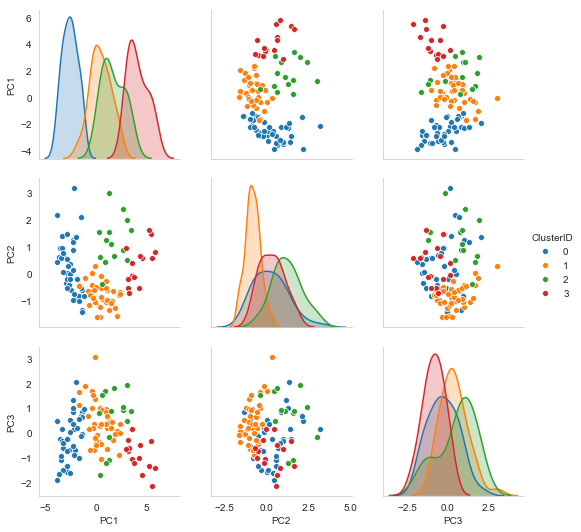

In [49]:
sns.pairplot(data = df_pca3_c4_hr, vars=['PC1', 'PC2', 'PC3'], hue='ClusterID')

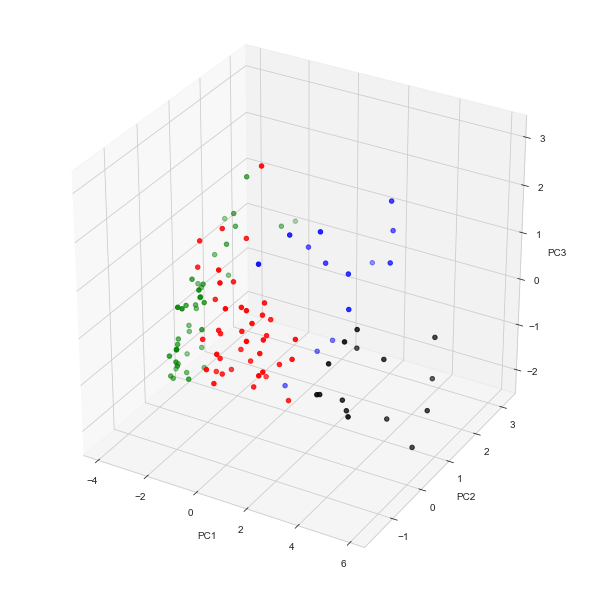

In [50]:
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig) 
ax.scatter(df_pca3_c4_hr['PC1'], df_pca3_c4_hr['PC2'], df_pca3_c4_hr['PC3'],
           c=df_pca3_c4_hr['ClusterID'].map({0:'green', 1:'red', 2:'blue', 3:'black'}), marker='o')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

<hr>

## 3. Get the cluster labels of outlier data.

In [51]:
df_s_o = df_outlier[col_list]
df_s_o = standard_scaler.transform(df_s_o) # s in df_s_o stands for scaled. o stands for outlier.

E:\Users\ASHISH\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  


In [52]:
df_s_o.round(2)[0:5] # our outlier data, but scaled. First 5 rows shown.

array([[ 2.99, -0.91, -0.92, -1.02, -1.17, -1.  , -2.78,  1.28, -1.03],
       [ 3.02, -0.73, -0.83, -0.84, -1.  , -0.26, -1.56,  2.2 , -0.89],
       [ 4.71, -0.88, -0.81, -0.81, -1.07, -0.42, -4.87,  0.03, -0.96],
       [ 3.31, -0.9 , -0.79, -1.01, -1.12,  1.56, -1.76,  1.28, -1.04],
       [-1.2 , 14.56, 19.63, 13.98,  6.02, -1.19,  1.7 , -1.22, 13.2 ]])

In [53]:
df_o_pca_tr = pca.transform(df_s_o) # our outlier data transformed with new features as principal components.
df_o_pca_tr.round(2)[0:5] # first 5 rows shown.

array([[-4.100e+00,  6.600e-01, -2.300e+00,  4.800e-01,  8.800e-01,
         7.400e-01, -5.900e-01, -1.600e-01,  2.000e-02],
       [-3.820e+00,  1.190e+00, -1.730e+00,  3.500e-01, -6.200e-01,
         5.800e-01, -5.400e-01, -2.800e-01, -1.000e-02],
       [-4.800e+00,  1.970e+00, -2.870e+00,  5.600e-01,  2.980e+00,
         1.330e+00, -1.980e+00, -4.500e-01,  1.200e-01],
       [-4.030e+00,  2.060e+00, -2.300e-01,  2.200e-01,  9.000e-02,
         4.900e-01, -1.420e+00, -2.500e-01,  4.000e-02],
       [ 2.574e+01,  1.186e+01, -1.075e+01,  3.790e+00, -1.700e+00,
        -6.050e+00, -4.690e+00,  4.000e+00, -2.100e-01]])

In [54]:
df_o_pca3 = df_o_pca_tr[:,0:3] # since we only require first 3 principal components to explain 89.5% variance.
df_o_pca3.round(2)[0:5] # look at first 5 rows.

array([[ -4.1 ,   0.66,  -2.3 ],
       [ -3.82,   1.19,  -1.73],
       [ -4.8 ,   1.97,  -2.87],
       [ -4.03,   2.06,  -0.23],
       [ 25.74,  11.86, -10.75]])

### 3.a.i. 3 clusters by K-means.

In [55]:
labels = model_clus3.predict(df_o_pca3)
len(labels)

56

In [56]:
# creation of data frame with labels for analysis of clusters formed.

df_dummy = pd.DataFrame.copy(df_outlier)
df_dummy.reset_index(inplace=True)
df_o_3_clus = pd.concat([df_dummy, pd.Series(labels)], axis=1)
df_o_3_clus.head()

,index,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,0
0,31,Central African Republic,149.0,52.63,17.75,118.19,888,2.01,47.5,5.21,446,0
1,32,Chad,150.0,330.10,40.63,390.19,1930,6.39,56.5,6.59,897,0
2,66,Haiti,208.0,101.29,45.74,428.31,1500,5.45,32.1,3.33,662,0
3,132,Sierra Leone,160.0,67.03,52.27,137.66,1220,17.20,55.0,5.20,399,0
4,8,Austria,4.3,24059.70,5159.00,22418.20,43200,0.87,80.5,1.44,46900,2


### 3.a.ii. 4 clusters by K-means.

In [57]:
labels = model_clus4.predict(df_o_pca3)
len(labels)

56

In [58]:
# creation of data frame with labels for analysis of clusters formed.

df_dummy = pd.DataFrame.copy(df_outlier)
df_dummy.reset_index(inplace=True)
df_o_4_clus = pd.concat([df_dummy, pd.Series(labels)], axis=1)
df_o_4_clus.head()

,index,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,0
0,31,Central African Republic,149.0,52.63,17.75,118.19,888,2.01,47.5,5.21,446,3
1,32,Chad,150.0,330.10,40.63,390.19,1930,6.39,56.5,6.59,897,3
2,66,Haiti,208.0,101.29,45.74,428.31,1500,5.45,32.1,3.33,662,3
3,132,Sierra Leone,160.0,67.03,52.27,137.66,1220,17.20,55.0,5.20,399,3
4,8,Austria,4.3,24059.70,5159.00,22418.20,43200,0.87,80.5,1.44,46900,0


### 3.b.i. 3 clusters by Hierarchical method.

We need to get the cluster labels for the outliers. In order to do so, I am computing the sum of squared distance of one outlier point with all the points in a cluster. The outlier will belong to the cluster from which it has the minimum distance. We repeat this for all outlier points.

In [59]:
distance_matrix = np.zeros((df_pca3.shape[0],df_o_pca3.shape[0])) # 111 x 55 matrix.

for i in range(distance_matrix.shape[1]):
    diff_in_points = df_pca3-df_o_pca3[i] # substract outlier row with every row of bigger matrix of size 111 x 3.
    sq_diff = np.square(diff_in_points) # square the distances.
    distances = sq_diff.sum(axis=1) # sum of squared distance. This is a 111D vector. The distance of outlier point from 
                                    # every other point which are already clustered.
    distance_matrix[:,i] = distance_matrix[:,i] + distances #append it to the distance_matrix. Every column represents dist
                                    # of outlier data point from other 111 points that has cluster labels.
    
print(distance_matrix.shape)
distance_matrix.round(1)

(111, 56)


array([[ 3.6,  1.8,  9.1, ..., 11. , 87.6, 85.8],
       [40.9, 37.4, 59.3, ..., 22.8, 61.1, 31.2],
       [40.5, 34. , 54.9, ...,  9.3, 35.3, 37.4],
       ...,
       [31.5, 27.3, 47.7, ..., 11.3, 57.6, 52.1],
       [24.1, 17.9, 32.8, ...,  0.7, 46.9, 76.1],
       [ 6.3,  3.1, 10.6, ...,  6.7, 73.2, 80.7]])

In [60]:
dist_list = []
for j in range(df_o_pca3.shape[0]):    
    for i in range(3) : # we have 3 cluster labels 0, 1 and 2.   
        indices = clusterCut[clusterCut==i].index # get indices of data points that belong to the same cluster.
        dist_list.append(distance_matrix[indices,j].sum()/len(indices)) # average of sum of squared distance from the cluster.
dist_clus = np.array(dist_list).reshape(df_o_pca3.shape[0],-1) # distance from clusters.
dist_clus.shape # 55 x 3 matrix. Rows are outlier data points. Elements are distances. Columns are clusters 0, 1 and 2.

(56, 3)

In [61]:
cluster_labels = np.argmin(dist_clus, axis=1) # outlier data will belong to the cluster from which it's distance is minimum

In [62]:
df_dummy = pd.DataFrame.copy(df_outlier)
df_dummy.reset_index(inplace=True)
df_o_3_clus_hr = pd.concat([df_dummy, pd.Series(cluster_labels)], axis=1)
df_o_3_clus_hr.head()

,index,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,0
0,31,Central African Republic,149.0,52.63,17.75,118.19,888,2.01,47.5,5.21,446,0
1,32,Chad,150.0,330.10,40.63,390.19,1930,6.39,56.5,6.59,897,0
2,66,Haiti,208.0,101.29,45.74,428.31,1500,5.45,32.1,3.33,662,0
3,132,Sierra Leone,160.0,67.03,52.27,137.66,1220,17.20,55.0,5.20,399,0
4,8,Austria,4.3,24059.70,5159.00,22418.20,43200,0.87,80.5,1.44,46900,2


### 3.b.ii. 4 clusters by Hierarchical method.

In [63]:
dist_list = []
for j in range(df_o_pca3.shape[0]):    
    for i in range(4) : # we have 3 cluster labels 0, 1, 2 and 3.   
        indices = clusterCut2[clusterCut2==i].index # get indices of data points that belong to the same cluster.
        dist_list.append(distance_matrix[indices,j].sum()/len(indices)) # average of sum of squared distance from the cluster.
dist_clus = np.array(dist_list).reshape(df_o_pca3.shape[0],-1) # distance from clusters.
dist_clus.shape # 42 x 4 matrix. Rows are outlier data points. Elements are distances. Columns are clusters 0, 1, 2 and 3.

(56, 4)

In [64]:
cluster_labels = np.argmin(dist_clus, axis=1) # outlier data will belong to the cluster from which it's distance is minimum
cluster_labels

array([0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 0, 2, 3], dtype=int64)

In [65]:
df_dummy = pd.DataFrame.copy(df_outlier)
df_dummy.reset_index(inplace=True)
df_o_4_clus_hr = pd.concat([df_dummy, pd.Series(cluster_labels)], axis=1)
df_o_4_clus_hr.head()

,index,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,0
0,31,Central African Republic,149.0,52.63,17.75,118.19,888,2.01,47.5,5.21,446,0
1,32,Chad,150.0,330.10,40.63,390.19,1930,6.39,56.5,6.59,897,0
2,66,Haiti,208.0,101.29,45.74,428.31,1500,5.45,32.1,3.33,662,0
3,132,Sierra Leone,160.0,67.03,52.27,137.66,1220,17.20,55.0,5.20,399,0
4,8,Austria,4.3,24059.70,5159.00,22418.20,43200,0.87,80.5,1.44,46900,3


<hr>

## 4. Merge the outlier data to original data.
### 4.a. By K-means.

In [66]:
df_k_3 = pd.concat([df_3_clus, df_o_3_clus], axis=0)
df_k_3 = df_k_3.set_index(keys='index').sort_index()
df_k_3.rename(columns={0:'ClusterID'}, inplace=True) # k stands for k-means clustering. 3 means 3 clusters.
df_k_3[['income', 'gdpp']] = df_k_3[['income', 'gdpp']].apply(pd.to_numeric)#check df.info().These columns are object type
#df_k_3.head()

In [67]:
#df_k_3.tail()

In [68]:
df_k_4 = pd.concat([df_4_clus, df_o_4_clus], axis=0)
df_k_4 = df_k_4.set_index(keys='index').sort_index()
df_k_4.rename(columns={0:'ClusterID'}, inplace=True) # 4 clusters data frame.
df_k_4[['income', 'gdpp']] = df_k_3[['income', 'gdpp']].apply(pd.to_numeric)#check df.info().These columns are object type
#df_k_4.head()

In [69]:
#df_k_4.tail()

### 4.a. By Hierarchical Clustering.

In [70]:
df_hr_3 = pd.concat([df_3_clus_hr, df_o_3_clus_hr], axis=0)
df_hr_3 = df_hr_3.set_index(keys='index').sort_index()
df_hr_3.rename(columns={0:'ClusterID'}, inplace=True)  # h stands for hierarchical clustering. 3 means 3 clusters.
df_hr_3[['income', 'gdpp']] = df_k_3[['income', 'gdpp']].apply(pd.to_numeric)#check df.info().These columns are object type
#df_hr_3.head()

In [71]:
#df_hr_3.tail()

In [72]:
df_hr_4 = pd.concat([df_4_clus_hr, df_o_4_clus_hr], axis=0)
df_hr_4 = df_hr_4.set_index(keys='index').sort_index()
df_hr_4.rename(columns={0:'ClusterID'}, inplace=True) # 4 clusters data frame.
df_hr_4[['income', 'gdpp']] = df_k_3[['income', 'gdpp']].apply(pd.to_numeric)#check df.info().These columns are object type
#df_hr_4.head()

In [73]:
#df_hr_4.tail()

<hr>

## 5. Inferences.
Let's see if k-means and hierarchical clustering created similar clusters.

In [74]:
df_k_3['ClusterID'].value_counts()

2    76
1    48
0    43
Name: ClusterID, dtype: int64

In [75]:
df_hr_3['ClusterID'].value_counts()

2    64
1    56
0    47
Name: ClusterID, dtype: int64

In [76]:
df_k_4['ClusterID'].value_counts()

0    70
2    40
3    31
1    26
Name: ClusterID, dtype: int64

In [77]:
df_hr_4['ClusterID'].value_counts()

3    63
0    46
1    41
2    17
Name: ClusterID, dtype: int64

It seems that both k-means and hierarchical have formed somewhat similar clusters.

In [78]:
# # getting csv files for analysis in tableau. Only addition is the new ClusterID column.

# df_k_3.to_csv('df_k_3.csv', encoding='utf-8', index=False)
# df_hr_3.to_csv('df_hr_3.csv', encoding='utf-8', index=False)
# df_k_4.to_csv('df_k_4.csv', encoding='utf-8', index=False)
# df_hr_4.to_csv('df_hr_4.csv', encoding='utf-8', index=False)

The best way to know if the clusters are correct is to visualize what countries are associated to which clusters.
#### K-Means Clustering with 3 Clusters.

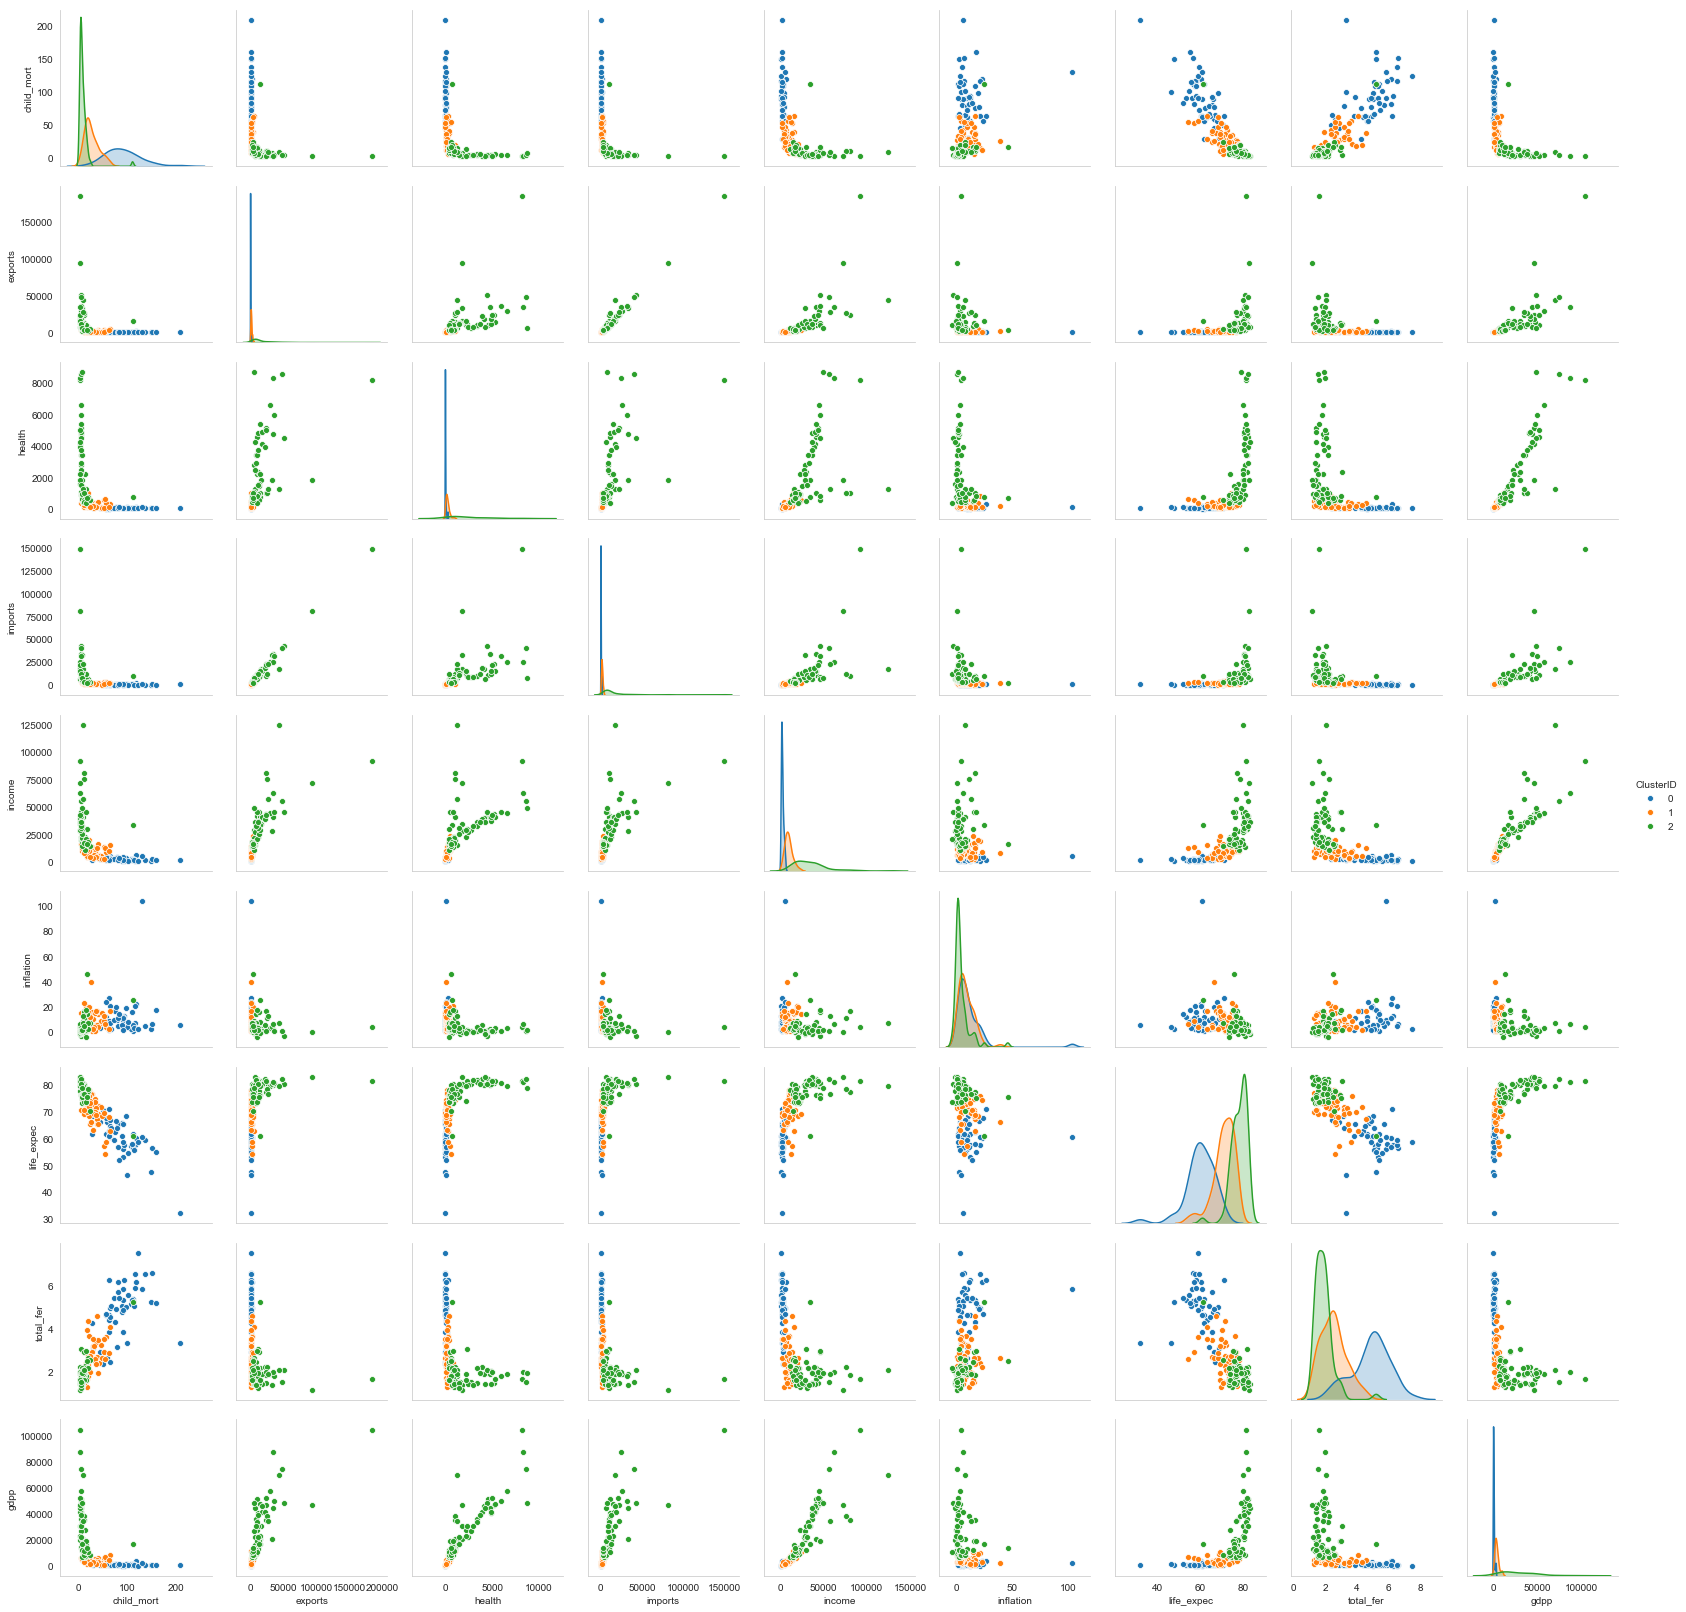

In [79]:
sns.pairplot(data = df_hr_3, vars=col_list, hue='ClusterID')

In [80]:
# check for mean and median of all the features.

grp_hr3 = df_hr_3.groupby('ClusterID')
f={} # empty dictionary.
for col in col_list:
    f[col]=['mean','median'] # creating a dictionary of what functions will be applied on what columns.
grp_hr3 = grp_hr3.agg(f)
grp_hr3 # Note that mean and median are very close for features. This signifies that our clusters are tight, which is good.

child_mort          exports             health            imports  \
                mean median      mean    median     mean   median      mean   
ClusterID                                                                     
0              90.85  89.30    312.27    161.42    58.10    45.74    420.28   
1              27.01  22.40   1565.11   1376.60   278.30   227.48   1784.38   
2               9.51   6.15  17764.38  10493.10  2471.23  1370.07  15321.50   

                       income        inflation        life_expec         \
             median      mean median      mean median       mean median   
ClusterID                                                                 
0            281.98   2284.96   1850     11.30   7.64      60.01  60.50   
1           1606.60   9447.68   8955      8.83   6.64      70.93  71.55   
2          10025.85  34792.19  30000      4.28   1.75      77.97  78.90   

          total_fer             gdpp         
               mean median      mean median  
ClusterID                                    
0              4.89   5.05   1004.98    769  
1              2.52   2.56   4423.57   4115  
2              1.90   1.86  29219.69  22300

In [81]:
# grp_hr3 = df_hr_3.groupby('ClusterID')
# median_df_hr3 = grp_hr3.median()
# median_df_hr3 # median statistic dataframe to be plotted in tablaeu.
# median_df_hr3.reset_index(inplace=True)

# # getting csv files for analysis in tableau. Only addition is the new ClusterID column.
# median_df_hr3.to_csv('median_df_hr3.csv', encoding='utf-8', index=False)

Check the stats in the table above as graphs. Note that in the graph, only median values of features are considered and not the mean.

In [82]:
%%HTML
<div class='tableauPlaceholder' id='viz1553206038347' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;7Y&#47;7YX5X7KQJ&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='path' value='shared&#47;7YX5X7KQJ' /> <param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;7Y&#47;7YX5X7KQJ&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1553206038347');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1000px';vizElement.style.height='827px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

So Hierarchical with 3 clusters makes some sense. Top countries like US, Canada, european countries like Finland, Sweden, Germany are clustered together. African countries are clustered along with Pakistan, Yemen.  India, China and other South American countries form one cluster.

<b>Characteristics of Clusters:</b>
1. ClusterID 0 (Red): This cluster has highest child mortality, lowest income and gdpp, highest inflation, lowest life expectancy and highest fertility rate. Note that instead of having high fertility rate, most of the children die because of diseases. This cluster contains African countries, Lao, afghanistan and Pakistan.

2. ClusterID 1 (Orange): This cluster contains countries which are in between better doing and worst countries, i.e., Cluster 0 and Cluster 2. Medium Child Mortality, Medium Income, High Inflation, Good Life Expectancy, Apt Fertility rate, Medium GDPP. Some countries belonging to this country are: China, Russia, India, Brazil, etc.

3. ClusterID 2 (Green): This cluster contains first world countries. Low child mortality, High Health and Life Expectancy, Good Exports, High GDPP and Income, etc. US, Nordic Countries, European Countries, Australia, Gulf Countries, Japan, etc. belong to this Cluster.

<font size=10>Conclusion 1:</font><font size=5>Hierarchical Clustering done with 3 clusters is the most simple, accurate and easy to explain. I have compared it with results of other clustering. This is the final model that I have selected for further clustering. The characteristics of clusters of assigned countries can be seen just above.</font><br><br>
You can go to 2nd Jupyter Notebook now. 2.Analysis - HELP, Clustering of Countries with ClusterID 2.<br><br>
Other clustering and statistics associated with them are shown below.<br>
<hr>

## Additional.
#### 3. K-Means Clustering with 3 Clusters.

In [83]:
%%HTML
<div class='tableauPlaceholder' id='viz1553206127291' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Cl&#47;ClusteringonCountriesClusterID0&#47;K-Means3Clusters&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='ClusteringonCountriesClusterID0&#47;K-Means3Clusters' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Cl&#47;ClusteringonCountriesClusterID0&#47;K-Means3Clusters&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1553206127291');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [84]:
# check for mean and median of all the features.
grp_k3 = df_k_3.groupby('ClusterID').agg(f)
grp_k3

child_mort          exports            health            imports  \
                mean median      mean   median     mean   median      mean   
ClusterID                                                                    
0              94.79  90.30    313.49   140.40    59.88    45.74    429.47   
1              28.94  25.60   1155.88  1059.18   200.15   187.79   1499.21   
2              12.19   7.45  15398.44  8479.60  2161.74  1019.69  13287.18   

                      income        inflation        life_expec         \
            median      mean median      mean median       mean median   
ClusterID                                                                
0           281.98   2177.28   1780     11.80   8.79      59.35  60.10   
1          1506.19   7419.58   7325      8.00   6.04      71.18  71.55   
2          8242.95  31755.26  27750      5.37   2.48      76.50  77.30   

          total_fer             gdpp         
               mean median      mean median  
ClusterID                                    
0              5.12   5.11   1004.88    738  
1              2.59   2.60   3299.25   3165  
2              1.95   1.87  25834.74  18200

3 Clusters formed by Hierarchical method is OK overall, but one thing is questionable here. US is clustered with African countries.

#### K-Means Clustering with 4 Clusters.

In [85]:
%%HTML
<div class='tableauPlaceholder' id='viz1553206236079' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Cl&#47;ClusteringonCountriesClusterID0&#47;K-Means4Clusters&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='ClusteringonCountriesClusterID0&#47;K-Means4Clusters' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Cl&#47;ClusteringonCountriesClusterID0&#47;K-Means4Clusters&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1553206236079');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [86]:
# check for mean and median of all the features.
grp_k4 = df_k_4.groupby('ClusterID').agg(f)
grp_k4

child_mort          exports            health            imports  \
                mean median      mean   median     mean   median      mean   
ClusterID                                                                    
0              10.62    6.8  16504.96  9965.20  2308.28  1160.01  14200.84   
1              53.83   50.9    515.07   431.34    78.47    68.12    607.01   
2              26.01   20.5   1575.43  1431.86   282.94   243.10   1981.22   
3             103.47   99.7    241.52   131.99    49.59    40.63    360.17   

                      income        inflation        life_expec         \
            median      mean median      mean median       mean median   
ClusterID                                                                
0          9586.80  33352.86  28700      5.27   2.17      77.30  78.05   
1           581.65   4313.85   4110     17.74  12.30      67.23  67.85   
2          1903.88   9066.75   9410      6.07   5.29      71.25  72.65   
3           248.51   1730.10   1500      7.30   5.45      57.22  57.90   

          total_fer             gdpp         
               mean median      mean median  
ClusterID                                    
0              1.93   1.86  27515.86  20250  
1              3.55   3.17   1614.77   1310  
2              2.49   2.56   4309.25   4390  
3              5.32   5.31    791.94    595

Clusters remain almost the same. New cluster is formed from some smaller european countries, Asian countries like Thailand, Myanmar, some african and South American countries.

#### 4. Hierarchical Clustering with 4 Clusters.

In [87]:
%%HTML
<div class='tableauPlaceholder' id='viz1553206283249' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Cl&#47;ClusteringonCountriesClusterID0&#47;Hierarchical4Clusters&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='ClusteringonCountriesClusterID0&#47;Hierarchical4Clusters' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Cl&#47;ClusteringonCountriesClusterID0&#47;Hierarchical4Clusters&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1553206283249');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [88]:
# check for mean and median of all the features.
grp_hr4 = df_hr_4.groupby('ClusterID').agg(f)
grp_hr4

child_mort          exports             health            imports  \
                mean median      mean    median     mean   median      mean   
ClusterID                                                                     
0              90.00  88.75    306.25    150.91    56.80    45.19    420.60   
1              25.72  21.10   1243.94   1082.37   219.21   193.85   1697.80   
2              35.58  26.10   2416.56   2082.08   434.02   365.68   1946.89   
3               9.39   6.10  17985.29  10710.00  2499.93  1459.14  15526.99   

                       income        inflation        life_expec         \
             median      mean median      mean median       mean median   
ClusterID                                                                 
0            280.96   2222.67   1835      9.28   7.39      60.00  60.55   
1           1565.19   7628.78   7350      6.48   5.44      72.13  72.50   
2           1648.00  13996.47  14500     22.26  15.90      67.69  69.10   
3          10030.20  35082.54  30400      3.62   1.74      78.01  79.10   

          total_fer             gdpp           
               mean median      mean   median  
ClusterID                                      
0              4.87   5.04    976.17    763.5  
1              2.50   2.54   3558.54   3310.0  
2              2.74   2.59   6920.59   6350.0  
3              1.89   1.86  29469.21  22500.0

Similar Clusters formed to K-Means with 4 Clusters.